In [43]:
import numpy as np
from scipy.stats.distributions import norm
import matplotlib.pylab as plt
import pandas as pd
import statsmodels.api as sm
import sys
sys.path.append('../zdrojaky')
import warnings; warnings.simplefilter('ignore')
from tsplot import tsplot
np.set_printoptions(precision=4, suppress=True)

# Téma 4: Modely MA a ARMA

## Moving average, MA(q) - modely klouzavých průměrů

Modely klouzavých průměrů, Moving Average, jsou dány předpisem

$$
X_t = \mu + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \ldots + \theta_q \varepsilon_{t-q}, \qquad \varepsilon_t\sim\ \mathrm{iid}\ \mathcal{N}(0, \sigma^2).
$$

Tento model vystihuje - prostřednictvím nezávislého bílého šumu - tzv. náhodné šoky, jež jsou nezávislé a přicházejí ze stejné distribuce, v našem případě normální centrované v nule a s konstatní variancí.

Jelikož ve vzorcích pro momenty potřebujeme i parametr pro $\varepsilon_t$, uvažujeme často $\theta_0=1$.

$$
\mathbb{E}[X_t] = \mu, \qquad\operatorname{var} X_t = \sigma^2 \cdot \sum_{i=1}^q \theta_i^2,
$$

a kovariancí

$$
\begin{aligned}
\gamma(k) = \operatorname{cov}(X_t, X_{t+k}) 
&= \operatorname{cov}\big(
\underbrace{\beta_0 \varepsilon_t + \ldots + \beta_q \varepsilon_{t-q}}_{X_t},
\underbrace{\beta_0 \varepsilon_{t+k} + \ldots + \beta_q \varepsilon_{t+k-q}}_{X_{t+k}}\big) \\
&=
\begin{cases}
0 & \text{pro}\ k>q,\\
\sigma^2 \cdot \sum_{i=0}^{q-k}\theta_i \theta_{i+k} &\text{pro}\ k=1,\ldots, q, \\
\gamma(-k) & \text{pro}\ k<0.
\end{cases}
\end{aligned}
$$

MA procesy jsou populární v celé řadě oborů, zejména v ekonometrii, kde náhodné šoky jsou připisovány rozhodnutím vlád, nedostatkům klíčových materiálů, v poslední době terorismu aj. Takové náhodné šoky se totiž velmi pravděpodobně propagují do dalších časových okamžiků, ale nikoliv přímým způsobem, jako v AR modelu.

Identifikace řádu MA modelu je vcelku dobře možná pomocí ACF. Naopak odhad MA modelu je složitý a spoléhá na numerickou optimalizaci, ale o tom až později.

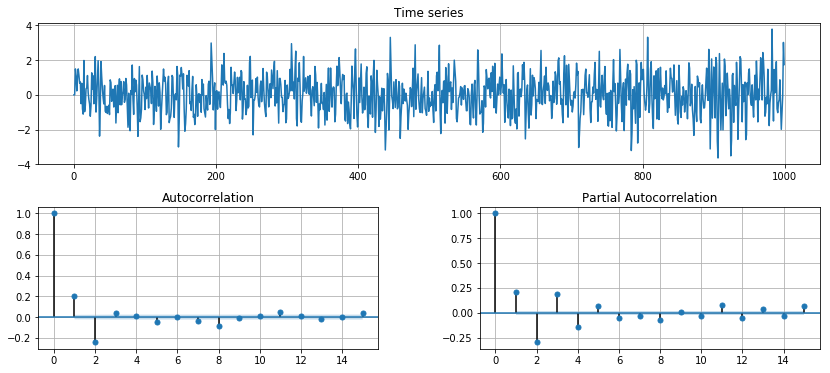

In [3]:
ndat = 1000
epsilon = np.random.normal(size=ndat)
x = np.zeros(ndat)
mean = 0
for t in range(2, ndat):
    x[t] = mean + epsilon[t] + .4*epsilon[t-1] - .3*epsilon[t-2]
tsplot(x)

### Invertibilita MA procesů

Zatímco u AR procesů nás zajímá stacionarita, již vyšetřujeme zjišťováním kořenů charakteristického polynomu, u MA procesů se zabýváme **invertibilitou**. Podívejme se na dva poměrně významně různé procesy MA(1) a jejich ACF a PACF:

In [73]:
from statsmodels.tsa.stattools import acf, pacf
ndat = 100000
epsilon = norm.rvs(size=ndat, random_state=123)
x = np.zeros(ndat)
z = np.zeros(ndat)
for t in range(2, ndat):
    x[t] = epsilon[t]+ 1/2*epsilon[t-1]
    z[t] = epsilon[t]+ 2*epsilon[t-1]
print('ACF(x):  ', acf(x, nlags=5, fft=True))
print('ACF(z):  ', acf(z, nlags=5, fft=True))
print('PACF(x):  ', pacf(x, nlags=5))
print('PACF(z):  ', pacf(z, nlags=5))

ACF(x):   [ 1.      0.4025 -0.0018 -0.0076 -0.007  -0.0037]
ACF(z):   [ 1.      0.4025 -0.0018 -0.0075 -0.007  -0.0037]
PACF(x):   [ 1.      0.4025 -0.1955  0.0893 -0.0495  0.0226]
PACF(z):   [ 1.      0.4025 -0.1955  0.0893 -0.0495  0.0226]


Co z toho plyne? ACF a PACF pro MA(1) proces s koeficientem $\theta$ je stejné, jako pro MA(1) proces s koeficientem $1/\theta$. To je velmi zásadní zjištění, neboť za určitých podmínek nejsme schopni odhadnout koeficienty jednoznačně.

Uvažujme MA(1) proces ve tvaru

$$
X_t = \varepsilon_t - \theta \varepsilon_{t-1}.
$$

Jelikož

$$
\varepsilon_t = X_t + \theta\varepsilon_{t-1} \qquad \text{a}\qquad
\varepsilon_{t-1} = X_{t-1} + \theta\varepsilon_{t-1}
$$

máme

$$
\begin{aligned}
\varepsilon_t &= X_t + \theta(X_{t-1} + \theta\varepsilon_{t-2}) \\
&= X_t + \theta X_{t-1} + \theta^2 \varepsilon_{t-2}.
\end{aligned}
$$

Je-li $|\theta|<1$, můžeme takovou substituci dělat "nekonečně" mnohokrát,

$$
\varepsilon_t = X_t + \theta X_{t-1} + \theta^2 \varepsilon_{t-2},
$$

což můžeme přepsat do podoby

$$
X_t = -\theta X_{t-1} - \theta^2 X_{t-2} - \theta^3 X_{t-3} - \ldots + \varepsilon_t.
$$

Neboli MA(1) proces s $|\theta|<1$ je možné invertovat do procesu AR($\infty$)!

V obecném případě procesu MA(q), resp. ARMA(p,q) - viz níže, definujeme charakteristický polynom ve tvaru

$$
\theta(x) = 1 - \theta_1 x - \theta_2 x^2 - \ldots - \theta_q x^q.
$$

Jsou-li kořeny tohoto polynomu vně jednotkové kružnice, potom existují koeficienty $\pi_1,\pi_2,\ldots$ takové, že

$$
X_t = \pi_1 X_{t-1} + \pi_2 X_{t-2} + \pi_3 X_{t-3} + \ldots + \varepsilon_t.
$$

MA procesy, které toto splňují, nazýváme **invertibilní**. Lze ukázat, že pro dané koeficienty ACF existuje právě jeden invertibilní MA proces.

## Smíšené modely ARMA(p, q)

Smíšené modely [ARMA](https://en.wikipedia.org/wiki/Autoregressive-moving-average_model) - AutoRegressive Moving Average - jsou jedny z nejpopulárnějších modelů v teorii časových řad. Jsou dány předpisem

$$
\begin{aligned}
X_t &= c + \phi_1 X_{t-1} + \ldots + \phi_p X_{t-p} + \varepsilon_t + \theta_1\varepsilon_{t-1} + \ldots + \theta_q \varepsilon_{t-q}, \qquad \varepsilon_t \sim \ \mathrm{iid}\ \mathcal{N}(0, \sigma^2) \\
&= c + \varepsilon_t + \sum_{i=1}^p \phi_i X_{t-i} + \sum_{i=1}^q \theta_i \varepsilon_{t-i}
\end{aligned}
$$

a neznámými parametry jsou zde $c, \phi_1, \ldots, \phi_p, \theta_1, \ldots, \theta_q, \sigma^2$. Většinou je předpokládána normalita šumu, nicméně modely mohou obstojně fungovat i při porušení tohoto předpokladu. Závažnější odchylky ale mohou vést ke zcestným výsledkům modelování.

ARMA modely měly v době svého vzniku ve srovnání s existujícími přístupy vynikající prediktivní vlastnosti. Teorie je připisována Peteru Whittleovi (1951), o rozšíření se potom postarali zejména pánové [George Box](https://en.wikipedia.org/wiki/George_E._P._Box) a [Gwilym Jenkins](https://en.wikipedia.org/wiki/Gwilym_Jenkins), po nichž se jmenuje i [Box-Jenkinsova metoda odhadu](https://en.wikipedia.org/wiki/Box–Jenkins_method).

ARMA modely jsou populární například v ekonometrii, popisují vývoj cen akcií, kde MA část se stará o šokové změny, zatímco AR část popisuje vývoj cen v závislosti na cenách předchozích. Navíc existuje celá řada různých rozšíření, např. NARMA (nonlinear ARMA), ARIMA (I = integrated), SARIMA (seasonal ARIMA), VARMA (vector ARMA) atd.

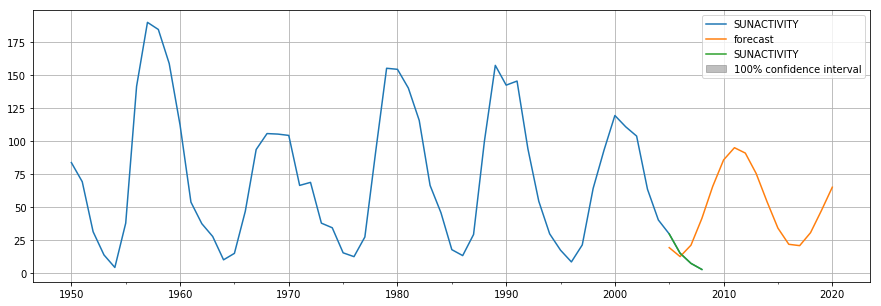

In [41]:
data = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
data.index = pd.DatetimeIndex(start='1700', end='2009', freq='A')
res = sm.tsa.ARMA(data, (3, 2)).fit()
fig, ax = plt.subplots(figsize=(15,5))
ax = data.loc['1950':].plot(ax=ax)
res.plot_predict('2005', '2020', dynamic=True, ax=ax, alpha=0, plot_insample=True)
plt.show()

## Smíšené modely ARIMA(p, d, q)

Jedním ze základních předpokladů ARMA modelu je slabá stacionarita časové řady $X_1, X_2, \ldots$. Co když je ale tento předpoklad porušen? Pak máme několik možností, z nichž jmenujme dvě nejčastější:

1. Odstranit trend, tj. rozložit časovou řadu na trend + zbytek a trend odečíst. Trend můžeme hledat interpolací řady polynomem odpovídajícího řádu. Predikce budoucích hodnot pak znamená vypočítat vyvoj trendu a k němu přidat predikce z "detredované" časové řady.
2. Použít metodu diferencí, tj. vytvořit z řady $\{X_t; t=1,2,\ldots\}$ řadu $\{X_{t}'; t=1,2,\ldots\}$ následovně:

$$
X_{t}' = X_{t} - X_{t-1}, \qquad t = 1,2,\ldots
$$

Pokud nepomůžou první diference, pomohou často druhé, udělané stejným způsobem z $\{X_t'\}$ atd. ARMA model, který toto "uvnitř" dělá, se nazývá ARIMA, kde I je od slova Integrated, což značí, že řada naintegrovává hodnoty. My toto integrování odstraňujeme diferencováním. Jejich počet je dán číslem d. Tedy ARIMA(3,2,1) je ARMA(3,1) s dvěma diferencováními.

Nutno podotknout, že ne vždy lze řady diferencování "zestacionárnit" a rovněž ne vždy vede diferencování k uspokojivému výsledku. Analýza je vždy žádoucí. Porovnejme si to na obrázku níže:

<Figure size 1080x216 with 0 Axes>

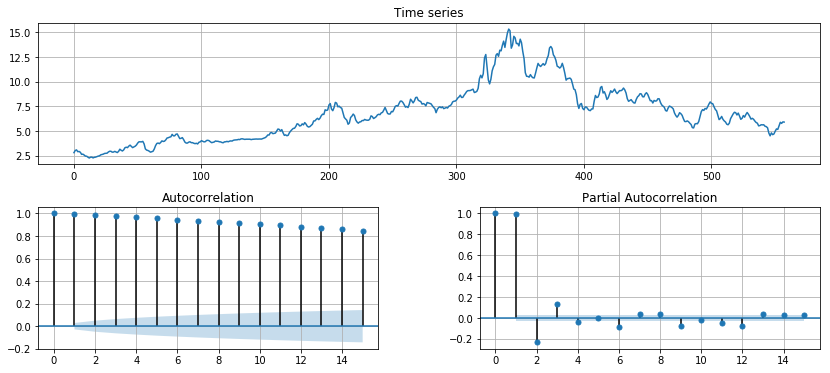

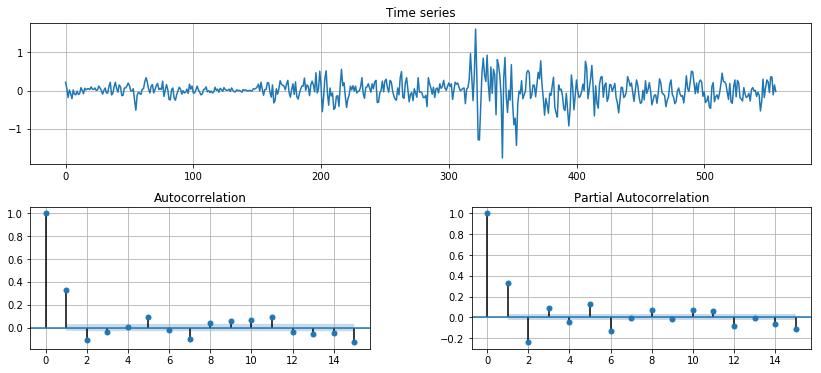

In [38]:
# Monthly yields on treasury securities
fn = '../zdrojaky/tcm10y.csv'
data = np.genfromtxt(fn, delimiter=',', usecols=1, skip_header=1)
data_dif = data[1:] - data[:-1]
plt.figure(figsize=(15, 3))
tsplot(data)
tsplot(data_dif)

### Box-Jenkinsonův přístup k ARMA modelům

Přístup spočívá ve třech krocích:

1. Identifikace modelu - posouzení stacionarity a sezónnosti časové řady, odhalení přítomnosti AR a MA částí a jejich řádů, např. pomocí ACF a PACF či vhodnými informačním kritériem (AIC,BIC). Časová řada je v případě potřeby transformována tak, aby byla stacionarita zajištěna, např. diferencováním (počítáním rozdílů $X_t - X_{t-1}$).
2. Odhad parametrů - obvykle pomocí MLE.
3. Ověření modelu - posouzení nekorelovanosti reziduí a jejich slabé stacionarity v čase, např. pomocí ACF a PACF.

Existují do jisté míry opodstatněné názory, že Box-Jenskinsonův přístup je v samotném základu problematický, např. kvůli stacionaritě. Velmi často je tedy spíš než ARMA model vhodný nějaký stavový model, který lze analyticky odhadovat např. Kalmanovým filtrem.

# Odhad ARMA modelu

Odhad parametrů ARMA modelu, stejně tak, jako jednotlivých složek, můžeme provést např. hrubou silou - zkoušením všech možných kombinací hodnot parametrů. Trochu lepší metodou je odhad metodou maximální věrohodnosti, MLE (maximum likelihood estimation), na kterou se podíváme níže.

### MLE odhad AR(1) procesu

Uvažujme stacionární gaussovský AR(1) proces

$$
X_t = c + \phi X_{t-1} + \varepsilon_t, \qquad \varepsilon_t \sim\  \mathrm{iid}\ \mathcal{N}(0, \sigma^2), |\phi|<1\quad \text{(proč?)}
$$

Neznámé parametry jsou tedy $c, \phi$ a $\sigma^2$.

Z minulé přednášky už víme, že

$$
\mathbb{E}[X_1] = \mu = \frac{c}{1-\phi}, \qquad \operatorname{var} X_1 = \frac{\sigma^2}{1-\phi^2},
$$

a jelikož šum je normální (gaussovský), platí

$$
X_1 \sim \mathcal{N}(\mu, \operatorname{var} X_1) = \mathcal{N}\left( \frac{c}{1-\phi}, \frac{\sigma^2}{1-\phi^2}\right).
$$

Připomeňme, že hustota pravděpodobnosti takového normálního rozdělení je

$$
f(x_1; c, \phi, \sigma^2) = f(x_1; c, \phi, \sigma^2) = \frac{1}{\sqrt{2\pi} \sqrt{\sigma^2/(1 - \phi^2)}}
\exp
\left[
-\frac{1}{2} \frac{[x_1 - [c/(1-\phi)]^2}{\sigma^2/(1-\phi^2)}
\right].
$$

Podívejme se nyní na druhé pozorování $X_2$, které je v autoregresním modelu podmíněné $X_1$,

$$
X_2 = c + \phi X_1 + \varepsilon_2 \qquad \Rightarrow X_2|X_1=x_1 \sim \mathcal{N}\left((c+\phi x_1), \sigma^2\right),
$$

neboť zde je $X_1$ bráno jako deterministická konstanta $x_1$. Tedy ke konstantě $(c+\phi x_1)$ přičítáme šum z $\mathcal{N}(0, \sigma^2)$ a

$$
f(x_2|x_1;c, \phi, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp 
\left[
-\frac{1}{2} \frac{(x_2 - c - \phi x_1)^2}{\sigma^2}
\right].
$$

Podobně budeme mít $(X_3|X_2, X_1) = (X_3|X_2)$ atd., neboť do modelu v čase $t$ vstupuje na pravé straně jen $X_{t-1}$. Tedy hustota v čase $t$ je

$$
f(x_t|x_{t-1}, x_{t-2}, \ldots, x_1; c, \phi, \sigma^2) = f(x_t|x_{t-1}; c, \phi, \sigma^2)
$$

a věrohodnostní funkce ("pravděpodobnost") všech pozorování do času $T$

$$
f(x_T, x_{T-1},\ldots, x_1;c, \phi, \sigma^2) = f(x_1;c, \phi, \sigma^2) \prod_{t=2}^{T} f(x_t|x_{t-1}; c, \phi, \sigma^2).
$$

Logaritmus věrohodnosti - log-likelihood - je tedy

$$
\begin{aligned}
\mathcal{L}(c, \phi, \sigma^2) &= \log f(x_1;c, \phi, \sigma^2) + \sum_{t=2}^{T} \log f(x_t|x_{t-1}; c, \phi, \sigma^2) \\
&= \underbrace{
-\frac{1}{2} \log (2\pi) - \frac{1}{2} \log\left(\frac{\sigma^2}{1-\phi^2}\right)
- \frac{\left( x_1 - \frac{c}{1-\phi}\right)^2}{2 \frac{\sigma^2}{1-\phi^2}}
}_{\log f(x_1;c, \phi, \sigma^2)}
\underbrace{
-\frac{T-1}{2} \log(2\pi) - \frac{T-1}{2}\log(\sigma^2) - \sum_{t=1}^{T} \frac{\varepsilon_t^2}{2\sigma^2}
}_{\log\prod f(x_t|x_{t-1};c, \phi, \sigma^2)},
\end{aligned}
$$

kde $\varepsilon_t = x_t - c - \phi x_{t-1}$. Ta se nám budou hodit u odhadu MA části.

Nyní bychom položili log-likelihood rovný nule a hledali maximum přes parametry $c, \phi, \sigma^2$, což je úkol iterativní a pro počítač :-)

### Conditional MLE - metoda podmíněné maximální věrohodnosti pro AR(1)

Alternativně k výše uvedené plné věrohodnosti lze uvažovat hodnotu $y_1$ deterministickou a tedy $f(y_1) = 1$. Potom maximalizujeme log-likelihood podmíněný prvním pozorováním, tedy jen tu součtovou část $\sum \log f(x_t|x_{t-1}; c, \phi, \sigma^2)$,

$$
\mathcal{L}^*(c, \phi, \sigma^2) = -\frac{T-1}{2} \log(2\pi) - \frac{T-1}{2}\log(\sigma^2) - \sum_{t=1}^{T} \frac{\varepsilon_t^2}{2\sigma^2}.
$$

Dá se ukázat, že toto odpovídá odhadu pomocí nejmenších čtverců.

## Conditional MLE pro AR(p)

Mějme nyní autoregresní model řádu $p$, tedy

$$
X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + \varepsilon_t, \qquad \varepsilon_t \sim \ \mathrm{iid}\ \mathcal{N}(0, \sigma^2).
$$

Nyní je vektor parametrů $[c, \phi_1, \ldots, \phi_p, \sigma^2]^\intercal$. Kdybychom postupovali jako u AR(1), ukázalo by se, že podmíněná maximální věrohodnost bude pracovat s log-likelihoodem

$$
\mathcal{L}^*(c, \phi_1,\ldots,\phi_p, \sigma^2) = -\frac{T-p}{2} \log(2\pi) - \frac{T-p}{2}\log(\sigma^2) - \sum_{t=p1}^{T} \frac{\varepsilon_t^2}{2\sigma^2}.
$$

### MLE pro MA(1)

Uvažujme nyní proces klouzavých průměrů MA(1) ve tvaru

$$
X_t = \mu + \varepsilon_t + \theta \varepsilon_{t-1}, \qquad \varepsilon_t \sim \ \mathrm{iid}\ \mathcal{N}(0, \sigma^2), |\theta|<1.
$$

Nyní je vektor neznámých parametrů $[\mu, \theta, \sigma^2]^\intercal$.

Pokud bychom chtěli odvozovat věrohodnostní funkci pro celý soubor $\mathbf{x} = [X_1=x_1, X_2=x_2, \ldots, X_T=x_T]^\intercal$, dostali bychom se k hustotě

$$
f(y_T, y_{T-1},\ldots, y_1; \mu, \theta, \sigma^2)
= (2\pi)^{-\frac{T}{2}} |\mathbf{\Omega}|^{-\frac{1}{2}} \exp
\left[
-\frac{1}{2} (\mathbf{x}-\mathbf{\mu})^\intercal \mathbf{\Omega}^{-1} (\mathbf{x}-\mathbf{\mu})
\right],
$$

kde $\mathbf{\mu}$ je vektor identických středních hodnot o délce $T$ a

$$
\mathbf{\Omega} = \mathbb{E}\left[(\mathbf{y}-\mathbf{\mu})(\mathbf{y}-\mathbf{\mu})^\intercal\right]
= \sigma^2
\begin{bmatrix}
(1+\theta^2) & \theta & 0 & \ldots & 0 \\
\theta & (1+\theta^2) & \theta & \ldots & 0 \\
0 & \theta & (1+\theta^2) & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \ldots & (1+\theta^2)
\end{bmatrix}
$$

Nezbylo by, než použít numerickou optimalizaci.

### Conditional MLE pro MA(1)

Už víme, že

$$
\mathbb{E}[X_t] = \mu \qquad\text{a}\qquad
\operatorname{var}X_t = \sigma^2(1+\theta^2).
$$

Jelikož šum je z normálního rozdělení, je i $X_1\sim\mathcal{N}(\mu, \sigma^2(1+\theta^2))$. Uvažujme nyní $X_2$ za podmínky pozorovaného $X_1=x_1$. Vidíme, že

$$
X_2 = \mu + \varepsilon_2 + \theta\varepsilon_1.
$$

Okamžitě je patrné, že $X_1=x_1$ nepřináší žádnou informaci o stochastickém šumu $\varepsilon_1$ resp. $\varepsilon_0$ v prvním pozorování! Nezbyde tedy než zavést nějaké další omezení, např. $\varepsilon_0 = 0$. Potom

$$
X_1|\varepsilon_0 = 0 \sim \mathcal{N}(\mu, \sigma^2) \qquad\text{z čehož plyne}\qquad \varepsilon_1 = y_1 - \mu,
$$

a tedy

$$
(X_2|X_1=y_1, \varepsilon_0 = 0) \sim \mathcal{N}(\mu+\theta\varepsilon_1, \sigma^2).
$$

Zavedený předpoklad umožňuje dopočítat celou posloupnost $\{\varepsilon_1, \varepsilon_2,\ldots,\varepsilon_T\}$ z $\{x_1,x_2,\ldots,x_T\}$ iterováním přes

$$
\varepsilon_t = x_t - \mu - \theta \varepsilon_{t-1}.
$$

Podmíněná věrohodnostní funkce potom vypadá

$$
\begin{aligned}
f(x_t|x_{t-1},\ldots, y_1, \varepsilon_0 = 0; \mu, \theta, \sigma^2) 
&= f(x_t|\varepsilon_{t-1}, \varepsilon_0=0; \mu, \theta, \sigma^2) \\
&= \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left[ -\frac{\varepsilon_t^2}{2\sigma^2} \right]
\end{aligned}
$$

a podmíněný log-likelihood pro celý balík dat do času $T$

$$
\begin{aligned}
\mathcal{L}^{*}(\mu, \theta, \sigma^2) 
&= \log f(x_T, x_{T-1},\ldots, x_1|\varepsilon_0=0; \mu, \theta, \sigma^2) \\
&= \prod_{t=2}^T f(x_t|\varepsilon_{t-1}; \mu, \theta, \sigma^2) \\
&= -\frac{T}{2} \log(2\pi) - \frac{T}{2}\log(\sigma^2) - \sum_{t=1}^T \frac{\varepsilon_t^2}{2\sigma^2}.
\end{aligned}
$$

Stojí tedy za zmínku, že pro vzorek o rozsahu $T$ je odhad MA(1) podmíněným MLE použit celý balík vzorků, neboť podmiňováno je na $\varepsilon_0$, nikoliv $X_1$. Maximalizaci musíme provádět optimalizací.

### Conditional MLE pro MA(q)

Uvažujeme-li MA(q) ve tvaru

$$
X_t = \mu + \varepsilon_t + \theta_1\varepsilon_{t-1} + \ldots + \theta_q \varepsilon_{t-q}, \qquad \varepsilon_t \sim\ \mathrm{iid}\ \mathcal{N}(0, \sigma^2),
$$

potřebujeme odhadnout parametry $\mu, \theta_1, \ldots, \theta_q, \sigma^2$. Plný MLE odhad odpovídá MA(1) uvedenému výše. Analogicky, podmíněný odhad postavíme na předpokladu

$$
\varepsilon_0 = \varepsilon_{-1} = \ldots = \varepsilon_{-q+1} = 0
$$

a celou posloupnost $\{\varepsilon_1, \ldots, \varepsilon_T\}$ dopočítáváme z dat $\{x_1, \ldots, x_T\}$ rekurzivně

$$
\varepsilon_t = x_t - \mu - \theta_1\varepsilon_{t-1} - \theta_2 \varepsilon_{t-2} - \ldots - \theta_q\varepsilon_{t-q}.
$$

Podmíněný log-likelihood je nakonec tedy stejný, jako výše,

$$
\begin{aligned}
\mathcal{L}^{*}(\mu, \theta, \sigma^2) 
&= \log f(x_T, x_{T-1},\ldots, x_1|\varepsilon_0=0; \mu, \theta, \sigma^2) \\
&= \prod_{t=2}^T f(x_t|\varepsilon_{t-1}, \varepsilon_0=0; \mu, \theta, \sigma^2) \\
&= -\frac{T}{2} \log(2\pi) - \frac{T}{2}\log(\sigma^2) - \sum_{t=1}^T \frac{\varepsilon_t^2}{2\sigma^2}
\end{aligned}
$$

a maximalizaci musíme opět dělat metodami numerické optimalizace.

## Podmíněný odhad ARMA(p, q)

Uvažujme konečně ARMA(p, q) ve tvaru

$$
X_t = c + \phi_1 X_{t-1} + \ldots + \phi_p X_{t-p} + \varepsilon_t + \theta_1\varepsilon_{t-1} + \ldots + \theta_q \varepsilon_{t-q}, \qquad \varepsilon_t \sim \ \mathrm{iid} \mathcal{N}(0, \sigma^2),
$$

kde oba zúčastněné procesy AR i MA jsou slabě stacionární. Máme odhadnout $c, \phi_1, \ldots, \phi_p, \theta_1, \ldots, \theta_q, \sigma^2$. Pozorování v čase $(p+1)$ je dáno

$$
\begin{aligned}
X_{p+1} &= c + \phi_1 X_p +  \ldots + \phi_p X_1 + \varepsilon_{p+1} + \theta_1\varepsilon_p + \ldots + \theta_q \varepsilon_{p-q+1} \\
&\sim \mathcal{N}(c + \phi_1 X_p +  \ldots + \phi_p X_1, \sigma^2).
\end{aligned}
$$

Podmíněný log-likelihood počítaný od času $t=p+1$ do $T$ má tedy tvar

$$
\begin{aligned}
\mathcal{L}^*(c, \phi_1, \ldots, \phi_p, \theta_1, \ldots, \theta_q, \sigma^2)
&= \log f(x_T, x_{T-1},\ldots, x_{p+1}|x_p, \ldots, x_1, \varepsilon_p = \varepsilon_{p-1}=\ldots=\varepsilon_{p-q+1}=0; c, \phi_1, \ldots, \phi_p, \theta_1, \ldots, \theta_q, \sigma^2) \\
&= -\frac{T-p}{2} \log(2\pi) - \frac{T-p}{2} \log(\sigma^2) - \sum_{t=p+1}^T \frac{\varepsilon_t^2}{2\sigma^2},
\end{aligned}
$$

kde posloupnost $\{\varepsilon_{p+1}, \ldots, \varepsilon_T\}$ je dopočítávána z $\{x_1, \ldots, x_t\}$ iterativně pomocí

$$
\varepsilon_t = X_t - c - \phi_1 X_{t-1} -\ldots - \phi_p X_{t-p} - \theta_1\varepsilon_{t-1} - \ldots - \theta_q\varepsilon_{t-q}.
$$

Je tedy použit balík $T-p$ pozorování. Celý proces odhadu je samozřejmě implementován jako numerická optimalizace.